In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

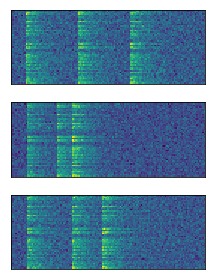

In [2]:
from twpca.datasets import jittered_population

pure_data = jittered_population(n_trial=50)[0]# + jittered_population()[0]
data = pure_data + 0.1*np.random.randn(*pure_data.shape)
data = data

fig, axes = plt.subplots(3, 1)
for ax, trial in zip(axes, data):
    ax.imshow(trial.T)
    ax.set_xticks([])
    ax.set_yticks([])
fig.tight_layout()

In [11]:
from twpca import TWPCA

model = TWPCA(n_components=49, smoothness=1)
model.fit(data)
aligned_data = model.transform()
reconstructed_data = model.reconstruct()

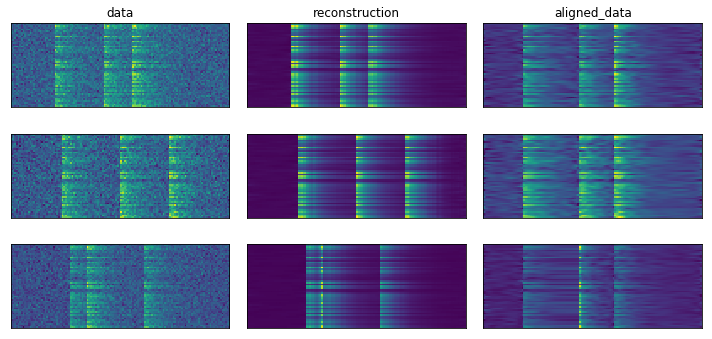

In [17]:
fig, axes = plt.subplots(3, 3, figsize=(10,5))
idx = np.random.permutation(data.shape[0])
for ax, raw_trial, atrial, rtrial in zip(axes, data[idx], aligned_data[idx], reconstructed_data[idx]):
    ax[0].imshow(raw_trial.T)
    ax[1].imshow(rtrial.T)
    ax[2].imshow(atrial.T)
    
for ax in axes.ravel():
    ax.set_xticks([])
    ax.set_yticks([])
    
axes[0,0].set_title('data')
axes[0,1].set_title('reconstruction')
axes[0,2].set_title('aligned_data')
fig.tight_layout()

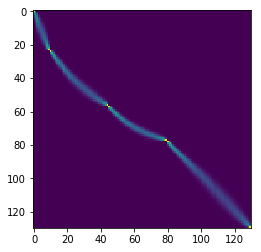

In [13]:
plt.imshow(model.warping_funcs[0])

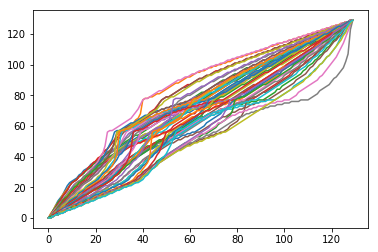

In [14]:
plt.plot(np.argmax(model.warping_funcs, axis=1).T);